In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from functools import partial
from tensorflow.keras.layers import Dense, Flatten
%matplotlib inline

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## First NN Project

##### Utility Functions

In [17]:
def get_info(X, y, X_test, y_test):
    print("X shape:", X.shape, "y shape:", y.shape)
    print("X_test shape:", X_test.shape, "y_test shape:", y_test.shape)
    
def inspect(X, y):
    print("X shape:", X.shape, "y shape:", y.shape)
    
def display_images(X, num_of_images=20, randomized=False):
    plt.figure(figsize=(12,2))
    if randomized: X = X[np.random.permutation(num_of_images)]
    else: X = X[:num_of_images]
    for index, image in enumerate(X):
        plt.subplot(num_of_images // 10, 10, index + 1)
        image = image.reshape(28, 28)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(image, cmap="gray")
    plt.show()
    
def split_train_validation(X, y, ratio_of_train_set=0.90): # assuming the data is already stratified, cleaned, and random
    if type(ratio_of_train_set) == float and (ratio_of_train_set > 0 and ratio_of_train_set < 1):
        train_size = int(X.shape[0] * ratio_of_train_set)
        X_train = X[:train_size]
        X_val = X[train_size:]
        y_train = y[:train_size]
        y_val = y[train_size:]
    elif type(ratio_of_train_set) == int and (ratio_of_train_set > 0 and ratio_of_train_set < X.shape[0]): 
        X_train = X[:ratio_of_train_set]
        X_val = X[ratio_of_train_set:]
        y_train = y[:ratio_of_train_set]
        y_val = y[ratio_of_train_set:]
    return (X_train, y_train, X_val, y_val) 

def clear():
    K = keras.backend
    K.clear_session()
    tf.random.set_seed(42)
    np.random.seed(42)
    
def inspect_model(model):
    layer_count = 1
    for layer in model.layers:
        print("Layer", layer_count, layer)
        layer_count += 1
    print(model.summary())

##### Loading in the Data

In [18]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
get_info(X_train_full, y_train_full, X_test, y_test)

X shape: (60000, 28, 28) y shape: (60000,)
X_test shape: (10000, 28, 28) y_test shape: (10000,)


##### Displaying Images

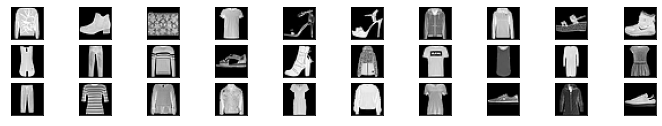

In [19]:
display_images(X_train_full, 30, randomized=True)

##### Splitting the Data

In [20]:
X_train, y_train, X_val, y_val = split_train_validation(X_train_full, y_train_full)
get_info(X_train, y_train, X_val, y_val)
inspect(X_test, y_test)

X shape: (54000, 28, 28) y shape: (54000,)
X_test shape: (6000, 28, 28) y_test shape: (6000,)
X shape: (10000, 28, 28) y shape: (10000,)


In [21]:
X_train.dtype

dtype('uint8')

In [22]:
y_train.dtype

dtype('uint8')

##### Normalizing the Data

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator

class FlattenData(TransformerMixin, BaseEstimator):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_copy = X.copy()
        return X_copy.reshape(X_copy.shape[0], -1)
       
class ReshapeData(TransformerMixin, BaseEstimator):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_copy = X.copy()
        return X_copy.reshape(X_copy.shape[0], 28, 28)
        
pipeline = Pipeline([
    ("flattener", FlattenData()),
    ("scaler", StandardScaler()),
    ("reshaper", ReshapeData()), 
])

X_train_scaled = pipeline.fit_transform(X_train)
X_val_scaled = pipeline.transform(X_val)
X_test_scaled = pipeline.transform(X_test)

##### Class Names

In [24]:
class_names = [ "T-shirt/top",
                "Trouser",
                "Pullover",
                "Dress",
                "Coat",
                "Sandal",
                "Shirt",
                "Sneaker",
                "Bag",
                "Ankle boot"]

##### Creating the Model

In [25]:
# Sequential API

clear()

# ! means it will not be fine-tuned

dense_hyperparams = {
    "activation": ["elu", "!softmax"],
    "kernel_initializer": ["he_normal", "!glorot_uniform"],
    "use_bias": False,
    "regularizer": {
        "type": "l2",
        "regularizer_factor": 0.01
    },
    "num_layers": 10,
    "num_of_neurons_per_layer": 100
}

batch_norm_hyperparams = {
    "momentum": 0.99
}

compile_hyperparams = {
    "loss": "!sparse_categorical_crossentropy",
    "optimizer": {
        "type": "SGD with Momentum",
        "momentum": 0.9,
        "learning_rate": 0.01
    }
    
}

def build_sequential_model_fn(activation="elu",
                              kernel_initializer="he_normal",
                              use_bias=False,
                              regularization_factor=0.01,
                              num_layers=10,
                              num_neurons=100,
                              momentum_factor=0.99,
                              SGD_momentum=0.9,
                              SGD_learning_rate=0.001):
    
    l2RegularizedDense = partial(
        Dense, 
        activation = activation, # elu
        kernel_initializer = kernel_initializer, # he_normal
        use_bias = use_bias, # don't use bias
        kernel_regularizer = keras.regularizers.l2(regularization_factor) # l2 0.01
    )

    sequential_model = keras.models.Sequential([
        Flatten(input_shape=[28, 28])
    ])

    for _ in range(num_layers): # 10 layers
        sequential_model.add(l2RegularizedDense(num_neurons)) # 100 neurons per hidden layer
        sequential_model.add(keras.layers.BatchNormalization(momentum=momentum_factor)) # batch norm after act fn

    # remember batch norm behaves uniquely during training and different in testing
        
    num_of_classes = len(class_names) # 10

    sequential_model.add(Dense(num_of_classes, activation="softmax", # softmax
                               kernel_initializer="glorot_uniform", # glorot_uniform
                               kernel_regularizer=keras.regularizers.l2(regularization_factor))) # l2 0.01
                                   
    sequential_model.compile(loss="sparse_categorical_crossentropy",
                             optimizer=keras.optimizers.SGD(momentum=SGD_momentum, learning_rate=SGD_learning_rate),
                             metrics=["accuracy"])
    
    return sequential_model

model = build_sequential_model_fn()

In [26]:
len(class_names)

10

In [27]:
inspect_model(model)

Layer 1 <tensorflow.python.keras.layers.core.Flatten object at 0x00000205F6B0BB48>
Layer 2 <tensorflow.python.keras.layers.core.Dense object at 0x00000205FFCEFB88>
Layer 3 <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x00000205FFCFBB88>
Layer 4 <tensorflow.python.keras.layers.core.Dense object at 0x00000205FFCB9D08>
Layer 5 <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x00000205FFCB9F88>
Layer 6 <tensorflow.python.keras.layers.core.Dense object at 0x00000205FFCAC9C8>
Layer 7 <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x00000205FFC99F48>
Layer 8 <tensorflow.python.keras.layers.core.Dense object at 0x00000205FFC22F88>
Layer 9 <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x00000205FFC97088>
Layer 10 <tensorflow.python.keras.layers.core.Dense object at 0x00000205FFCBAD88>
Layer 11 <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 

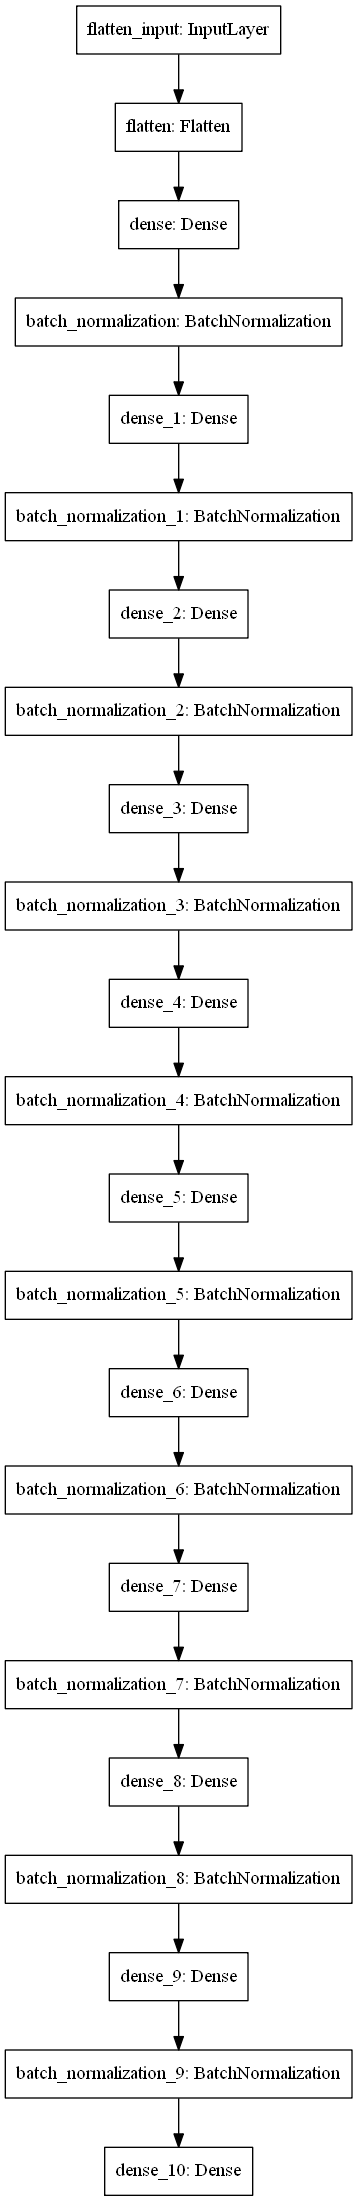

In [28]:
keras.utils.plot_model(model)

In [29]:
model.layers

##### Fitting the Model

In [30]:
done_training_project_1=True
if done_training_project_1 == False:
    K = keras.backend

    class ExponentialGrowth(keras.callbacks.Callback):
        def __init__(self, factor):
            self.factor = factor
            self.rates =[]
            self.losses = []
        def on_batch_end(self, batch, logs=None): # plot on a per batch basis
            self.rates.append(K.get_value(self.model.optimizer.lr))
            # print(logs) nans in losses??? I set momentum=True instead of momentum=float!
            self.losses.append(logs["loss"])
            K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

        def on_epoch_end(self, epoch, logs):
            logs["lr"] = K.get_value(self.model.optimizer.lr)

    def find_optimal_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
        init_weights = model.get_weights()
        factor = np.exp(np.log(max_rate/min_rate) / (len(X) // batch_size * epochs))
        init_lr = K.get_value(model.optimizer.lr)
        exp_growth = ExponentialGrowth(factor)
        callbacks = [exp_growth]
        model.fit(X_train_scaled, y_train, epochs=epochs, batch_size=batch_size, callbacks=callbacks)
        K.set_value(model.optimizer.lr, init_lr)
        model.set_weights(init_weights)
        return exp_growth.rates, exp_growth.losses

    rates, losses = find_optimal_learning_rate(model, X_train_scaled, y_train, batch_size=128)

    def plot_rates_vs_losses(rates, losses):
        plt.plot(rates, losses, "b--")
        plt.grid(True)
        plt.xlabel("Rates")
        plt.ylabel("Losses")
        plt.gca().set_xscale('log')
        plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 1.4])
        plt.show()

    plot_rates_vs_losses(rates, losses)

In [31]:
# rates[losses.index(min(losses))] # 1.775865

In [48]:
K = keras.backend

class OneCycleScheduler(keras.callbacks.Callback):
        def __init__(self, iterations, max_rate, start_rate=None,
                     last_iterations=None, last_rate=None):
            self.iterations = iterations
            self.max_rate = max_rate
            self.start_rate = start_rate or max_rate / 10
            self.last_iterations = last_iterations or iterations // 10 + 1
            self.half_iteration = (iterations - self.last_iterations) // 2
            self.last_rate = last_rate or self.start_rate / 1000
            self.iteration = 0
        def _interpolate(self, iter1, iter2, rate1, rate2):
            return ((rate2 - rate1) * (self.iteration - iter1)
                    / (iter2 - iter1) + rate1)
        def on_batch_begin(self, batch, logs):
            if self.iteration < self.half_iteration:
                rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
            elif self.iteration < 2 * self.half_iteration:
                rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                         self.max_rate, self.start_rate)
            else:
                rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                         self.start_rate, self.last_rate)
                rate = max(rate, self.last_rate)
            self.iteration += 1
            K.set_value(self.model.optimizer.lr, rate)
        def on_epoch_end(self, epoch, logs):
            logs["lr"] = K.get_value(self.model.optimizer.lr)

if done_training_project_1 == False:
    fit_hyperparams = {
        "epochs": 100,
        "batch_size": 32, 
        "callbacks": {""
            "EarlyStopping__patience": 20,
            "expogrowth_factor": "np.exp(np.log(10/10**-5) / (54000 // 32 * 100))",
            "expogrowth_min_rate": 10**(-5),
            "expogrowth_max_rate": 10,
            "1cycle__starting rate": 0.01, # from .compile(); starting lr
            "1cycle__max_rate": 0.05, # highest lr
            "1cycle__last_rate": 0.00001, # lowest lr
            "1cycle__climb": "(max - start)/half_iterations * iter + rate1",
            "1cycle__decline": "(start - max)/half_iterations * (iter - half_iterations) + max",
            "1cycle__decay": "(iterations - start)/(iterations - (2 * half_iterations)) * (iter - 2 * half_iterations)|| last_rate",
            "1cycle__last_iterations": "iterations // 10 + 1",
            "1cycle__half_iterations": "(iterations - last_iterations) // 2",
            "1cycle__second_to_last_rate": 0.01,
        }
    }

    # model is redefined because of prior 1cycle testing
    model = build_sequential_model_fn()

    import os

    def create_path():
        root_logdir = os.path.join(os.curdir, "my_logs")
        root_logdir = os.path.join(root_logdir, "first_NN_project")
        if not os.path.isdir(root_logdir):
                os.makedirs(root_logdir)
        return root_logdir
    root_logdir = create_path()

    def get_run_logdir():
        import time
        run_id = time.strftime("run_%Y_%m_%d-%H-%M-%S")
        return os.path.join(root_logdir, run_id)

    run_logdir = get_run_logdir()

    tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

    model_log_dir = os.path.join(root_logdir, "my_first_NN_project.h5")
    modelcheckpoint_cb = keras.callbacks.ModelCheckpoint(model_log_dir, save_best_only=True)

    early_stopping_cb = keras.callbacks.EarlyStopping(patience=20, 
                                                      restore_best_weights=True)

    # [tensorboard, modelcheckpoint, earlystopping, custom callback, 
    #  learningratescheduler, reducelronplateau]

    # learningratescheduler, schedule, reducelronplateau, custom callback => lr schedule

    total_batches = len(X_train_scaled) // 32 * 100

    callbacks=[tensorboard_cb, 
               modelcheckpoint_cb, 
               early_stopping_cb, 
               OneCycleScheduler(total_batches, max_rate=.017)]

    history = model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val),
                         epochs=100, batch_size=32, 
                         callbacks=callbacks)

In [33]:
# plt.plot(history.epoch, history.history["lr"])

In [34]:
# pd.DataFrame(history.history).plot(figsize=(8, 5))

##### TensorBoard Graphs

In [36]:
import os
root_logdir = os.path.join(os.curdir, "my_logs")
root_logdir = os.path.join(root_logdir, "first_NN_project\my_first_NN_project.h5")
model = keras.models.load_model(root_logdir) # loading in our best model

In [37]:
# %load_ext tensorboard 
# %tensorboard --logdir=./my_logs/first_NN_project --port=6006

##### Test Evaluation

In [38]:
if done_training_project_1 == False:
    metrics = model.evaluate(X_test_scaled, y_test)
    metrics

##### Predictions

In [39]:
if done_training_project_1 == False:
    y_proba = model.predict(X_test_scaled)
    y_pred = np.argmax(y_proba, axis=1)
    accuracy = np.sum(y_pred == y_test)/len(y_pred)
    print("Accuracy", accuracy)
    print("First 10 predictions", np.array(class_names)[y_pred[:10]])
    print("First 10 test instances", np.array(class_names)[y_test[:10]])

##### Fine-tuning

+ this should be done before evaluation

+ kerastuner tutorial:
+ https://www.youtube.com/watch?v=Clo1HKB50Ug&feature=emb_logo&ab_channel=NachiketaHebbar
+ TF doc kerastuner tutorial:
+ https://www.tensorflow.org/tutorials/keras/keras_tuner?hl=uk
+ kerastuner documentation:
+ https://keras-team.github.io/keras-tuner/documentation/hyperparameters/

In [50]:
import kerastuner as kt

finetuning_hyperparams = { # min, max, step
    "finetuning_methods": ["hyperband", "randomsearch", "bayesianoptimization", "sklearn"],
    "hp_reg_factor": [0.1, 0.9, 0.1], 
    "n_layers": [2, 10, 1],
    "n_neurons": [2, 100, 1],
    "batch_norm_momentum": [0.80, 0.99, 0.01],
    "output_layer_reg_factor": [0.1, 0.9, 0.1],
    "SGD_momentum": [0.80, 0.99, 0.01],
    "SGD_lr": [0.001, 0.1, 0.001],
    "epochs": [],
    "batch_size": [],
    "earlystopping__patience": [],
}

def build_model(hp):
    hp_l2_reg_factor = hp.Float("l2_reg_factor", min_value = 0.1, max_value = 0.9, step = 0.1)
    
    l2RegularizedDense = partial(
        Dense, 
        activation = "elu", 
        kernel_initializer = "he_normal",
        use_bias = False, 
        kernel_regularizer = keras.regularizers.l2(
            l2=hp_l2_reg_factor
        ) 
    )

    sequential_model = keras.models.Sequential([
        Flatten(input_shape=[28, 28])
    ])

    hp_n_layers = hp.Int("n_layers", min_value=2, max_value=10, step=1)
    hp_n_neurons = hp.Int("n_neurons", min_value=2, max_value=100, step=1)
    hp_batch_norm_momentum = hp.Float("batch_norm_momentum", min_value=0.80, max_value=0.99, step=0.01)
    
    for _ in range(hp_n_layers): 
        sequential_model.add(l2RegularizedDense(hp_n_neurons))
        sequential_model.add(keras.layers.BatchNormalization(momentum=hp_batch_norm_momentum)) 
        
    num_of_classes = len(class_names) # 10

    hp_output_layer_reg_factor = hp.Float("output_layer_reg_factor", min_value = 0.1, max_value = 0.9, step = 0.1)
    
    sequential_model.add(Dense(num_of_classes, activation="softmax", 
                               kernel_initializer="glorot_uniform", 
                               kernel_regularizer=keras.regularizers.l2(hp_output_layer_reg_factor)))
                   
    hp_SGD_momentum = hp.Float("SGD_momentum", min_value=0.80, max_value=0.99, step=0.01)
    hp_SGD_lr = hp.Float("learning_rate", min_value = 0.001, max_value = 0.1, step = 0.001)
        
    sequential_model.compile(loss="sparse_categorical_crossentropy",
                             optimizer=keras.optimizers.SGD(momentum=hp_SGD_momentum, learning_rate=hp_SGD_lr),
                             metrics=["accuracy"])
    return sequential_model

# how do I hypertune early_stopping patience, epochs, and batch size, all of which 
# are located in the .fit() method?

# hyperband tuner
hyperband_tuner = kt.Hyperband(
    build_model,
    objective = 'val_loss', 
    max_epochs = 12, # set slightly higher than default
    factor = 3,
    directory = 'my_dir',
    project_name = 'intro_to_kt'
)

# randomsearch tuner
randomsearch_tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='my_dir',
    project_name='helloworld'
)

# BayesianOptimization and Sklearn are also available; these might also be hyperparams

total_batches = len(X_train_scaled) // 32 * 100

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20, 
                                                      restore_best_weights=True)

callbacks=[early_stopping_cb, OneCycleScheduler(total_batches, max_rate=.017)]

hyperband_tuner.search(X_train_scaled, y_train, epochs=100, validation_data = (X_val_scaled, y_val),
                       callbacks=callbacks)

Trial 30 Complete [00h 01m 59s]
val_loss: 1.5439938306808472

Best val_loss So Far: 1.1780797243118286
Total elapsed time: 00h 18m 55s
INFO:tensorflow:Oracle triggered exit


##### Fine-tuning Results

In [60]:
hyperband_tuner.search_space_summary()
hyperband_tuner.get_best_hyperparameters()
hyperband_tuner.results_summary()

Search space summary
Default search space size: 7
l2_reg_factor (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.9, 'step': 0.1, 'sampling': None}
n_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 10, 'step': 1, 'sampling': None}
n_neurons (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 100, 'step': 1, 'sampling': None}
batch_norm_momentum (Float)
{'default': 0.8, 'conditions': [], 'min_value': 0.8, 'max_value': 0.99, 'step': 0.01, 'sampling': None}
output_layer_reg_factor (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.9, 'step': 0.1, 'sampling': None}
SGD_momentum (Float)
{'default': 0.8, 'conditions': [], 'min_value': 0.8, 'max_value': 0.99, 'step': 0.01, 'sampling': None}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.001, 'max_value': 0.1, 'step': 0.001, 'sampling': None}
Results summary
Results in my_dir\intro_to_kt
Showing 10 best trials
Objectiv

##### Training the Fine-tuned Model 

In [64]:
best_hps = hyperband_tuner.get_best_hyperparameters(num_trials=1)[0] # why do I need this?
model = hyperband_tuner.hypermodel.build(best_hps)
history = model.fit(X_train_scaled, y_train, epochs = 100, validation_data = (X_val_scaled, y_val),
          batch_size=32, callbacks=[early_stopping_cb, OneCycleScheduler(total_batches, max_rate=.017)])

Epoch 1/100
1688/1688 [==============================] - 5s 3ms/step - loss: 5.9322 - accuracy: 0.7426 - val_loss: 1.5103 - val_accuracy: 0.7663
Epoch 2/100
1688/1688 [==============================] - 5s 3ms/step - loss: 1.5152 - accuracy: 0.7629 - val_loss: 1.4712 - val_accuracy: 0.7757
Epoch 3/100
1688/1688 [==============================] - 5s 3ms/step - loss: 1.4336 - accuracy: 0.7701 - val_loss: 1.3741 - val_accuracy: 0.7738
Epoch 4/100
1688/1688 [==============================] - 5s 3ms/step - loss: 1.3717 - accuracy: 0.7690 - val_loss: 1.3132 - val_accuracy: 0.7813
Epoch 5/100
1688/1688 [==============================] - 5s 3ms/step - loss: 1.3259 - accuracy: 0.7676 - val_loss: 1.3245 - val_accuracy: 0.7197
Epoch 6/100
1688/1688 [==============================] - 5s 3ms/step - loss: 1.2924 - accuracy: 0.7651 - val_loss: 1.2971 - val_accuracy: 0.7330
Epoch 7/100
1688/1688 [==============================] - 5s 3ms/step - loss: 1.2650 - accuracy: 0.7641 - val_loss: 1.2187 - val_ac

In [65]:
metrics = model.evaluate(X_test_scaled, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 1.2000 - accuracy: 0.7661


+ **hyperhyperparameters** are the hyperparameters of your fine tuning algorithm
+ they work like higher order derivatives
+ you stop 1 level up (the first derivation/just hyperparameters, you don't **hypertune** your hyperparameters)
+ try raytune 
+ ASHA (asynchronous hyperband)
+ grid, ASHA, hyperband works best, maybe also bayesian optimization

In [ ]:
# predictions
# fine-tuning
# functional/subclassing API?
# transfer learning
# trying other optimizers, lr schedules, regularization techniques, act fn, kernel_inits

+ Optimizers
    + Adam, AdaMax, Nadam
    + RMSProp
    + AdaGrad
    + reg SGD <
    + SGD with momentum <
    + Nesterov Accelerated Gradients (NAG) or Nesterov Momentum Optimization (NMO)
+ lr schedules
    + power
    + exponential <
    + piecewise
    + performance
    + 1cycle <
+ regularization techniques
    + batch norm <
    + max-norm
    + l1
    + l2 <
    + l1_l2
    + dropout
    + MCDropout
+ act fn
    + ReLU
    + LeakyReLU
    + PReLU
    + RReLU
    + ELU <
    + SELU
+ kernel inits
    + glorot/xavier uniform/normal <
    + he uniform/normal <
    + lecun uniform/normal
+ miscellaneous
    + batch norm <
    + gradient clipping
    + transfer learning